In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing
import copy

from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from metrics import *

In [2]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterABC_high.csv',header=None)
scaler = MinMaxScaler()
scaler.fit(data)
# data = scaler.transform(data)*2-1

MinMaxScaler(copy=True, feature_range=(0, 1))

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


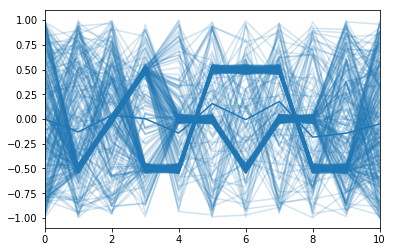

In [3]:
sns.tsplot(np.array(data), err_style="unit_traces")

In [5]:
class MapArray(object):
    def __init__(self, map_array = None, flg_direction = None):
        """
        Array that will map the indices whether its a row map or a col map
        """
        self._map_array = map_array
        self._flg_direction = flg_direction
        
    @property
    def map_array(self):
        return self._map_array
    
    @property
    def flg_direction(self):
        return self._flg_direction
    
    def __str__(self):
        str(self._map_array)
        
    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result


In [6]:
class Bicluster(object):
    
    def __init__(self, data, rho=None, gamma=None, bisected=False, H_max=None, best_bisection=None):
        """
        Bicluters structure
        
        
        :param rho: <np.array[int]> the map of the indices of rows of the bicluster i.e [2,4,7,8]
        :param gamma: <np.array[int]> the map of gammas, same structure f rho
        :param bisected: <boolean> indicates if the bicluster has been bisected recentky
        :param h_max: <float> best h from the last bisection
        :paran best_bisection: <MapArray> mapping array from the best bisection
        
        *Note: Noise will be represented as -1
        
        """
        self.gamma = gamma
        self.rho = rho
        self.bisected = bisected
        self.h_max = H_max
        self.bisected_direction = best_bisection.flg_direction if best_bisection is not None else None
        self.best_bisection = best_bisection
        self.data = data[np.ix_(np.where(self.rho>=0)[0], np.where(self.gamma>=0)[0])]

    def set_bisected(self):
        self.bisected = not self.bisected
    
    def __str__(self):
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))
                
    def row_length(self):
        return len(self.rho>=0)
    
    def col_length(self):
        return len(self.gamma>=0)
    
    def set_fields(self, best_bisection, h_max, bisected_direction):
        """
        Method
        
        :param best_bisection: <MapArray> Mapping array from the best bisection 
        :param h_max: <float> Best H from the last bisection
        :bisected_direction: <String> Direction from the last bisection ('cols' or 'rows')
        """
        self.best_bisection = best_bisection
        self.h_max = h_max
        self.bisected_direction = bisected_direction
        
        final_map = best_bisection.map_array == 0 # filtering noise then zeros

        if(bisected_direction == 'cols'):
            self.gamma = self.gamma[final_map]
            print(self.gamma)
        else:
            self.rho = self.rho[final_map]
            
    def compute_H(self, data):
        """
        Method:
        Computes the coherence H of the data
        """
        self.data = data[np.ix_(self.rho, self.gamma)]
        self.H = PairBasedCoherence(self.data).HP
        return self.H

In [35]:
def split_cols(data):
    """
    Function:
    Spits the bicluster according to the best split in of columns
    
    :param data: <np.array[np.array]> data of the bicluster to split
    :param bicluster: <Bicluster> data 
    """
    
    t_data = data.T
    aux_I, aux_J = t_data.shape
    
    aux_indices = np.zeros(aux_I)
    
    ma_coherence = 0
    middle = 0
    max_h = 0
    temp_max = 0
    flg_noise_cleaning = False
    for i in range(1, aux_I-1):
        # print(" i " + str(i))
        temp_h_right = PairBasedCoherence(t_data[i:len(t_data)]).HP
        # print("right " + str(temp_h_right))
        temp_h_left = PairBasedCoherence(t_data[0:i+1]).HP
        # print("left " + str(temp_h_left))
        temp_max = max(temp_h_right, temp_h_left)
        
        if (temp_max >= max_h):
            max_h = temp_max
            middle = i
            
    indices = np.ones(aux_I)
    """
    if(middle == 0 or middle == len(tmp_array)-1):
    tmp_array[middle] = -1
    flg_noise_cleaning = True
    """

    zeros = np.zeros(middle)
    
    if len(indices) == 1:
        indices = np.array([-1])
        
    if len(zeros) == 1:
        zeros = np.array([-1])
        
        
    indices[0:middle] = zeros
    
    indices = np.array(indices)
    
    unique_indices = np.unique(indices)
    
    if(len(unique_indices) == 2 and indices[0]==-1 and len(indices) >3):
        flg_noise_cleaning = True
    
    map_array = MapArray(indices, 'cols')
    
    return map_array, max_h, flg_noise_cleaning

In [36]:
def transform_dm(dm):
    dm = 1-dm**4
    np.fill_diagonal(dm, 0)
    return dm

In [50]:
def split_rows(data, min_cluster_size):
    """
    Apply DBSCAN over the bicluster to filter noise
    
    :param bicluster: <Bicluster> data
    :param min_cluster_size
    """
    n_cols = data.shape[1]
    dm = np.asarray([[((PositiveNegativeCorrelation(p1,p2,len(p1)).H_pos) 
                       if (PositiveNegativeCorrelation(p1,p2,len(p1)).H_pos)!= 1 else 0.0) 
                      for p2 in data] for p1 in data])
    dm = transform_dm(dm)
    # plt.hist(dm)
    gmm = GaussianMixture(n_components=3)
    gmm.fit(np.array([(dm).flatten()]).T)
    eps = gmm.means_[np.where(gmm.weights_==(min(gmm.weights_)))].flatten()
    dev = gmm.covariances_.flatten()[np.where(gmm.weights_==(min(gmm.weights_)))]
    bound = 0 #eps - 8*dev # eps-4*dev
    rows = np.array([])
    while (eps + 2*dev) > bound:
        db = DBSCAN(eps = eps ,metric='precomputed', min_samples=min_cluster_size
               ).fit(dm)
        rows = db.labels_
        if(len(np.unique(db.labels_))<3):
            eps -= dev/4
            if eps <= 0:
                eps = 1.0e-15
                break
        else:
            # print(eps)
            break
    # print(db.labels_)
    map_array = MapArray(db.labels_,'cols')    
    tmp_bicluster_label = 0
    max_h = 0
    # print("DEBUG LABELS")
    # print(db.labels_)
    
    for i in np.unique(rows):
        if i == -1:
            pass
        else:
            # print(str(np.where(rows == i)))
            temp_h = PairBasedCoherence(data[np.where(rows == i)]).HP
            if temp_h >= max_h:
                max_h = temp_h
                tmp_bicluster_label = i
    # print("%DEBUG% " + " MAP ARRAY " + str(map_array.map_array) + " BEST LABEL " + str(tmp_bicluster_label))
    final_array = np.array([1 if value == tmp_bicluster_label else (0 if value != -1 else -1) 
                            for value in db.labels_])
    map_array = MapArray(final_array, 'rows')
    
    flg_noise_cleaning = False
    unique_array = np.unique(final_array)
    if (len(unique_array) == 2 and unique_array[0] == -1):
        flg_noise_cleaning = True
    return map_array, max_h, flg_noise_cleaning

In [51]:
def compute_bicluster_coherence(bicluster, min_cluster_row_size):
    """
    Splits bicluster and chooses wether its better to split rows or columns
    
    :param bicluster: <Bicluster> Bicluster to split
    """
    print("compute coherence")
    
    flg_noise_cleaning_rows = False
    flg_noise_cleaning_cols = False
    
    if (bicluster.bisected):
    
        return bicluster.best_bisection.map_array, bicluster.h_max, bicluster.bisected_direction
    else:
        map_array_cols, h_cols, flg_noise_cleaning_cols = split_cols(bicluster.data)
        map_array_rows, h_rows, flg_noise_cleaning_rows = split_rows(bicluster.data, min_cluster_row_size)
        print("h cols " + str(h_cols) + " h rows " + str(h_rows))
        if (h_cols > h_rows):
            
            if flg_noise_cleaning_cols:
                print("clean cols")
                return map_array_cols, h_cols, "clean cols"
            print("split cols")
            return map_array_cols, h_cols, "cols"
        
        else:
            
            if flg_noise_cleaning_rows:
                print("clean rows")
                return map_array_rows, h_rows, "clean rows"
            print("split rows")
            return map_array_rows, h_rows, "rows"

In [52]:
class STSSCAN(object):
    
    def __init__(self, data, n_clusters = 2):
        """
        STSSCAN
        
        Applies biclustering over data
        
        :param data: <np.array> The data to apply biclusters
        :param n_clusters: <int> The number of biclusters to find
        
        """
        assert data is not None, "Empty data"
        self._data = data
        """ Data to apply biclustering """
        self._I, self._J = self._data.shape
        """ Stores shape of data """
        self._n_clusters = n_clusters
        """ Number of clusters to find """
        self._biclusters = list()
        """ List of biclusters composed by Bicluster Class"""
        self._objective_function = 0
        """ Objective function: maximize with boundary 1"""
    
    @property
    def n_clusters(self):
        return self._n_clusters
    
    @property
    def data(self):
        return self._data
    
    @property
    def biclusters(self):
        return self._biclusters
            
    def fit(self):
        """
        Fits the data on the algorithm. Iters over the 
        number of biclusters until find the requested number
        """
        print("Fitting data ")
        n_iterations = 0
        n_clusters = self._n_clusters
        initial_bicluster = Bicluster(self._data, np.arange(self._I), np.arange(self._J))
        self._biclusters.append(initial_bicluster)
        while len(self._biclusters) != self.n_clusters:
            self._split_biclusters()
        self._prune()
                
    def _split_biclusters(self):
        
        """
        Splits bicluters in order to find the next biclusters that optimizes
        the sum of coherences among biclusters
        """
        """ Initialize variables """
        # import ipdb; ipdb.set_trace()
        print()
        print("Splitting biclusters ")
        
        h_max = 0
        tmp_bicluster_delta = 0
        tmp_bisection = None
        tmp_split = 'cols'
        tmp_bisection_direction = None
        position = 0
        best_position = 0
        best_bisection_array = np.array([])
        best_bisection_direction = None
        
        
        
        """ Iterate over the biclusters"""
        while position != len(self._biclusters):
            
            print("Position " + str(position))
            
            """ If shape of the biclusters is within the bounds """ 
            bicluster = self._biclusters[position]
            print("Row length " + str(bicluster.row_length()) + " Col length " + str(bicluster.col_length()))
            min_cluster_row_size = math.floor((np.log(self._I)*5))
            if (bicluster.row_length() >= min_cluster_row_size and bicluster.col_length() > 3):
            
                """ Compute the bicluster coherence """
                tmp_bisection, tmp_bicluster_delta, tmp_split = compute_bicluster_coherence(bicluster,min_cluster_row_size)
                
                
                """ Store the best split of biclusters """
                if (tmp_split == 'clean cols'):
                    # To implement
                    # print("DEBUG CLEAN COLS" )
                    
                    index_map = tmp_bisection.map_array.copy()>=0
                    # print(index_map)
                    rho = self._biclusters[position].rho.copy()
                    new_gamma = self._biclusters[position].gamma.copy()[index_map]
                    self._biclusters[position] = Bicluster(self._data,rho ,new_gamma)
                    best_bisection_direction = 'clean'
                elif (tmp_split == 'clean rows'):
                    # print("DEBUG CLEAN ROWS")
                    index_map = tmp_bisection.map_array.copy()>=0
                    # print(index_map)
                    rho = self._biclusters[position].rho.copy()[index_map]
                    new_gamma = self._biclusters[position].gamma.copy()
                    self._biclusters[position] = Bicluster(self._data,rho ,new_gamma)
                    best_bisection_direction = 'clean'
            
                else:
                    
                    if(tmp_bicluster_delta >= h_max):
                        h_max = tmp_bicluster_delta
                        best_position = position
                        best_bisection_array = tmp_bisection.map_array.copy()
                        best_bisecton_flg_direction = 'cols' if tmp_bisection.flg_direction == 'cols' else 'rows'
                        best_bisection_direction = 'cols' if tmp_bisection.flg_direction == 'cols' else 'rows'                 
            position += 1
        """ Add the bicluster to the list of biclusters """
        if best_bisection_direction != 'clean':
            best_bisection = MapArray(best_bisection_array, best_bisection_direction)
            self._add_bicluster(best_position, best_bisection, h_max, best_bisection_direction)
    
    def _add_bicluster(self,best_position, best_bisection, h_max,bisection_direction):
        """
        Adds the found bicluster into the list of labels
        
        :param best_position: <int> position of the best bicluster
        :param best_bisection: <MapArray> map_array of the best bisection
        :param max_delta: h_max 
        """
        """ If the bisection is on rows """
       
        # Create the new bicluster
        best_rho = self._biclusters[best_position].rho
        best_gamma = self._biclusters[best_position].gamma
        index_map = best_bisection.map_array >= 1
        aux_index_map = best_bisection.map_array == 0
        if(bisection_direction == 'cols'):
            new_rho = best_rho.copy()
            new_gamma = best_gamma[index_map].copy()
            aux_rho = best_rho.copy()
            aux_gamma = best_gamma[aux_index_map].copy()
        else:
            new_gamma = best_gamma.copy()
            new_rho = best_rho[index_map].copy()
            aux_rho = best_rho[aux_index_map].copy()
            aux_gamma = best_gamma.copy()
        new_bicluster=Bicluster(self._data, new_rho, new_gamma)
        
        self._biclusters.append(new_bicluster)
        # Modify the bicluster that is going to be bisected
        self._biclusters[best_position] = Bicluster(self._data, aux_rho, aux_gamma)
        
    def _prune(self):
        
        for position in range(0,len(self._biclusters)):
            
            print(position)
            
            rho = self._biclusters[position].rho
            gamma = self._biclusters[position].gamma
            
            if len(gamma) > 4:
                
                stds = np.std(self._data[np.ix_(rho,gamma)], axis = 0)
                std = np.mean(stds)
                lst_map = list()

                print("std " + str(std))

                for index in [0, len(stds)-1]:
                    if (stds[index] <= std*3):
                        lst_map.append(1)
                    else:
                        lst_map.append(0)

                print(lst_map)


                    
                

In [53]:
stsscan = STSSCAN(np.array(data),6)

In [54]:
stsscan.fit()

Fitting data 

Splitting biclusters 
Position 0
Row length 300 Col length 11
compute coherence
h cols 0.888554928857 h rows 0.94589220852
split rows

Splitting biclusters 
Position 0
Row length 163 Col length 11
compute coherence
h cols 0.899713319964 h rows 0.943452205451
split rows
Position 1
Row length 104 Col length 11
compute coherence
h cols 0.95273102055 h rows 0.92617507362
split cols

Splitting biclusters 
Position 0
Row length 163 Col length 11
compute coherence
h cols 0.899713319964 h rows 0.943452205451
split rows
Position 1
Row length 104 Col length 3
Position 2
Row length 104 Col length 8
compute coherence
h cols 0.95273102055 h rows 0
split cols

Splitting biclusters 
Position 0
Row length 163 Col length 11
compute coherence
h cols 0.899713319964 h rows 0.943452205451
split rows
Position 1
Row length 104 Col length 3
Position 2
Row length 104 Col length 3
Position 3
Row length 104 Col length 5
compute coherence
h cols 0.960837996384 h rows 0
clean cols

Splitting biclust

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


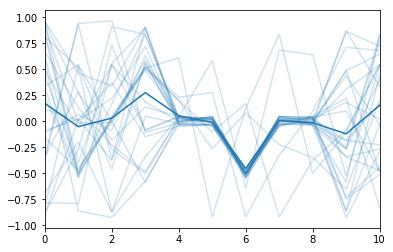

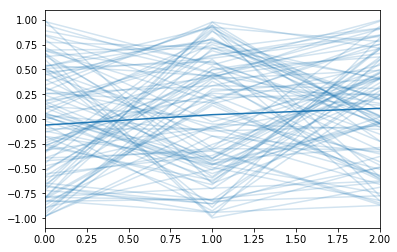

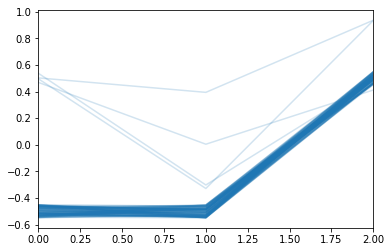

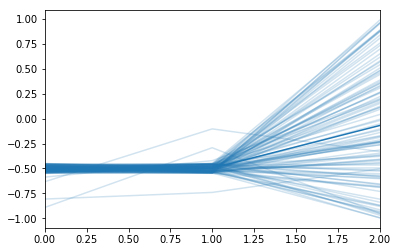

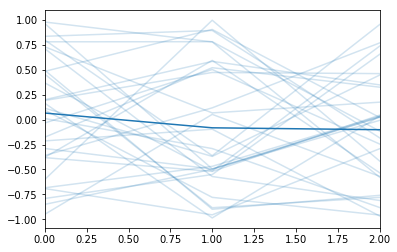

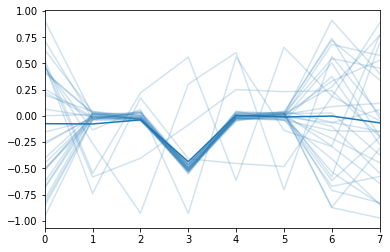

In [56]:
for i in range(0,6):
    sns.tsplot(np.array(data)[np.ix_(stsscan.biclusters[i].rho,stsscan.biclusters[i].gamma)],err_style="unit_traces")
    plt.show()
    plt.gcf().clear()

In [186]:
sns.tsplot(np.array(data)[np.ix_(stsscan.biclusters[i].rho,stsscan.biclusters[i].gamma)],err_style="unit_traces")

IndexError: too many indices for array